## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## Important imports

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import random
import os
#%matplotlib qt
%matplotlib inline

## Function to plot images

In [2]:
def get_plot_dic(image, title="", cmap=None):
    d = {
            "image" : image,
            "title": title,
            "cmap": cmap
        }
    return d

def plot_multiple_images(list_image_title_cmap, columns, rows, figsize=(18, 24)):
    """
    This fuction will be used for plot multiple images
    list_image_title is list of dictionary.
    dict = {
        "image": np.ndarray,
        "tilte": string (optional, default is ""),
        "cmap": string (optional, default is None)
    }
    """
    num_images = len(list_image_title_cmap)
        
    fig = plt.figure(figsize=figsize)
    # ax enables access to manipulate each of subplots
    ax = []
    for i in range(num_images):
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title(list_image_title_cmap[i].get('title', ""))
        plt.imshow(list_image_title_cmap[i]['image'], cmap = list_image_title_cmap[i].get('cmap', None))
    plt.show()
    
    return

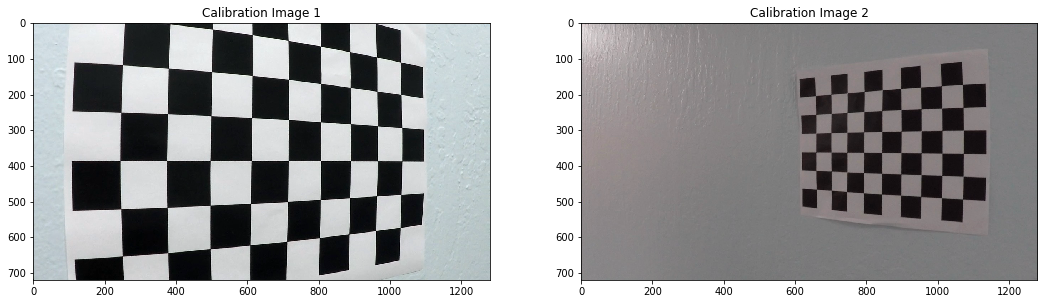

In [3]:
calibration_images = glob.glob('camera_cal/calibration*.jpg')
images = []
for i in range(2):
    img = cv2.imread(random.choice(calibration_images))
    images.append(get_plot_dic(img, title="Calibration Image {}".format(i+1), cmap=None))
    
plot_multiple_images(images, rows=1, columns=2, figsize=(18, 24))

## Camera calibration using chessboard imges

There are 9 corners in a row and 6 in a column.

In [4]:
def calibrate_camera(images_path, x_corners, y_corners,  save_pickle='camera_cal/calibration_parms_pickle.p'):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((y_corners*x_corners, 3), np.float32)
    objp[:,:2] = np.mgrid[0:y_corners, 0:x_corners].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    img = cv2.imread(images_path[0])
    img_size = (img.shape[1], img.shape[0])
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images_path):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (y_corners, x_corners), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dic = {
        'mtx': mtx,
        'dist': dist
    }
    
    pickle.dump(dic, open(save_pickle, "wb"))
    return mtx, dist
    


In [5]:
# Calling calibration function to get camera and distortion matrix
# This mtx and dist will be use for undistort images
mtx, dist = calibrate_camera(images_path=calibration_images, x_corners=9, y_corners=6)

## Testing on Calibration Images

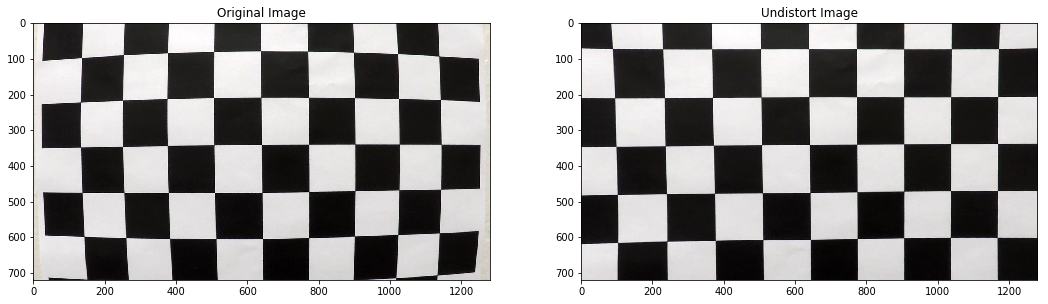

In [6]:
# img_path = random.choice(calibration_images)
# print(img_path)
img_path = 'camera_cal/calibration1.jpg'
img = cv2.imread(img_path)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
if img_path == 'camera_cal/calibration1.jpg':
    cv2.imwrite('output_images/undistort_calibration1.jpg', undist_img)
images = []
images.append(get_plot_dic(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), title="Original Image", cmap=None))
images.append(get_plot_dic(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), title="Undistort Image", cmap=None))

plot_multiple_images(images, rows=1, columns=2, figsize=(18, 24))

## Undistort Images for Test Images 

test_images/test5.jpg


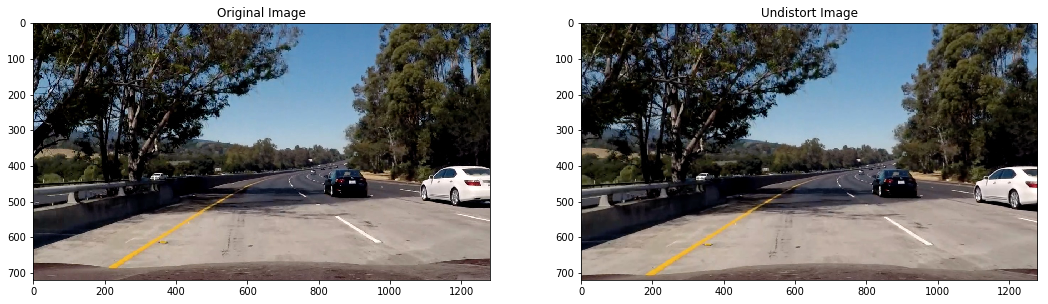

In [7]:
test_images = glob.glob('test_images/*.jpg')
img_path = random.choice(test_images)
print(img_path)
img = cv2.imread(img_path)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
if img_path == 'camera_cal/calibration1.jpg':
    cv2.imwrite('output_images/undistort_calibration1.jpg', undist_img)
images = []
images.append(get_plot_dic(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), title="Original Image", cmap=None))
images.append(get_plot_dic(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), title="Undistort Image", cmap=None))

plot_multiple_images(images, rows=1, columns=2, figsize=(18, 24))

## Functions to Create Thresholded Binary Image

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, hls_s=False):
    # Convert to grayscale
    if hls_s:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        gray = np.copy(s_channel)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), hls_s=False):
    # Convert to grayscale
    if hls_s:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        gray = np.copy(s_channel)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), hls_s=False):
    # Grayscale
    if hls_s:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        gray = np.copy(s_channel)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def create_thresholded_binary_image(image, plot_images=False):
    """
    image: RGB Image
    plot_image: True is want to plot intermediate and final binary images else False
    """
    if plot_images:
        images = []
        images.append(get_plot_dic(image, title="Original", cmap=None))

    # Run the function
    hls_s_flag = True
    grad_x = abs_sobel_thresh(image, orient='x', thresh_min=10, thresh_max=160, hls_s=hls_s_flag)
    if plot_images:
        images.append(get_plot_dic(grad_x, title="Grad X", cmap='gray'))
    
    grad_y = abs_sobel_thresh(image, orient='y', thresh_min=10, thresh_max=160, hls_s=hls_s_flag)
    if plot_images:
        images.append(get_plot_dic(grad_y, title="Grad Y", cmap='gray'))
        
#     mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(10, 200), hls_s=hls_s_flag)
#     if plot_images:
#         images.append(get_plot_dic(mag_binary, title="Grad Magnitude", cmap='gray'))
    
#     dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3), hls_s=hls_s_flag)
#     if plot_images:
#         images.append(get_plot_dic(dir_binary, title="Direction", cmap='gray'))

    combined = np.zeros_like(grad_x)
    combined[((grad_x==1) & (grad_y==1))] = 225
    
    if plot_images:
        images.append(get_plot_dic(combined, title="Combined", cmap='gray'))
    if plot_images:
        plot_multiple_images(list_image_title_cmap=images, columns=2, rows=2, figsize=(18, 15))
    return combined

Image path: test_images/straight_lines2.jpg


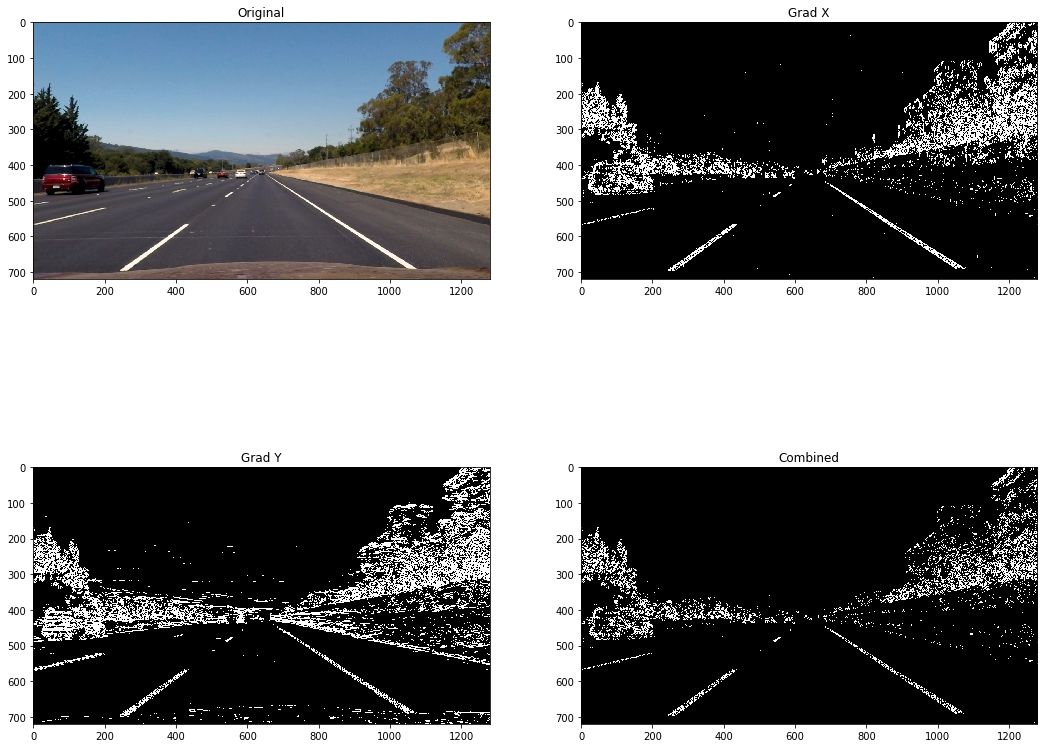

In [9]:
# Create thresholed binary image on test images
test_images = glob.glob('test_images/*.jpg')
img_path = random.choice(test_images)
img_path = 'test_images/straight_lines2.jpg'
print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

binary_img = create_thresholded_binary_image(image=cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), plot_images=True)

## Prespective Transform Matrix

By using fairly simple lane line (straight lane lines), we will find prespective transform matrix and its inverse 
matrix

In [10]:
def get_prespective_transform_matrix(img_path='test_images/straight_lines1.jpg', save_file='prespective_trans.p'):
    img = cv2.imread(img_path)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    y, x, _ = undist_img.shape
    bottom_y = y-1
    top_y = 450
    bottom_left = (190, bottom_y)
    top_left = (594, top_y)
    
    bottom_right = (1130, bottom_y)
    top_right = (691, top_y)
    color = [0, 0, 255]
    color_2 = [0, 255, 0]
    line_width = 2
    cv2.line(undist_img, bottom_left, top_left, color, line_width)
    cv2.line(undist_img, bottom_left, bottom_right, color, 10)
    cv2.line(undist_img, top_right, bottom_right, color, line_width)
    cv2.line(undist_img, top_right, top_left, color_2, line_width)
    
    offset = 200
    dst = np.float32([(offset, 0), (x-offset, 0), (x-offset, bottom_y), (offset, bottom_y)])
    src = np.float32([top_left, top_right, bottom_right, bottom_left])
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist_img, M, (x, y))
#     print(warped.shape)
#     cv2.line(warped, (offset+17, bottom_y), (offset+17, 0), color_2, 3)
#     cv2.line(warped, (x-offset-25, bottom_y), (x-offset-25, 0), color_2, 3)  

    unwaraped = cv2.warpPerspective(warped, M_inverse, (x, y))
    
    # Save images for writeup
    prefix = 'prespective_straight_lines1'
    out_dir = 'output_images'
    cv2.imwrite(os.path.join(out_dir, '{}_before_tranform.jpg'.format(prefix)), undist_img)
    cv2.imwrite(os.path.join(out_dir, '{}_after_transform.jpg'.format(prefix)), warped)
    cv2.imwrite(os.path.join(out_dir, '{}_after_revert_transform.jpg'.format(prefix)), unwaraped)
    
    images = []
    images.append(get_plot_dic(image=cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), title="Before Transform"))
    images.append(get_plot_dic(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), title="After Transform"))    
    images.append(get_plot_dic(cv2.cvtColor(unwaraped, cv2.COLOR_BGR2RGB), title="After Revert Transform"))
    
    plot_multiple_images(images, rows=2, columns=2, figsize=(18, 10))
    
    
    return M, M_inverse

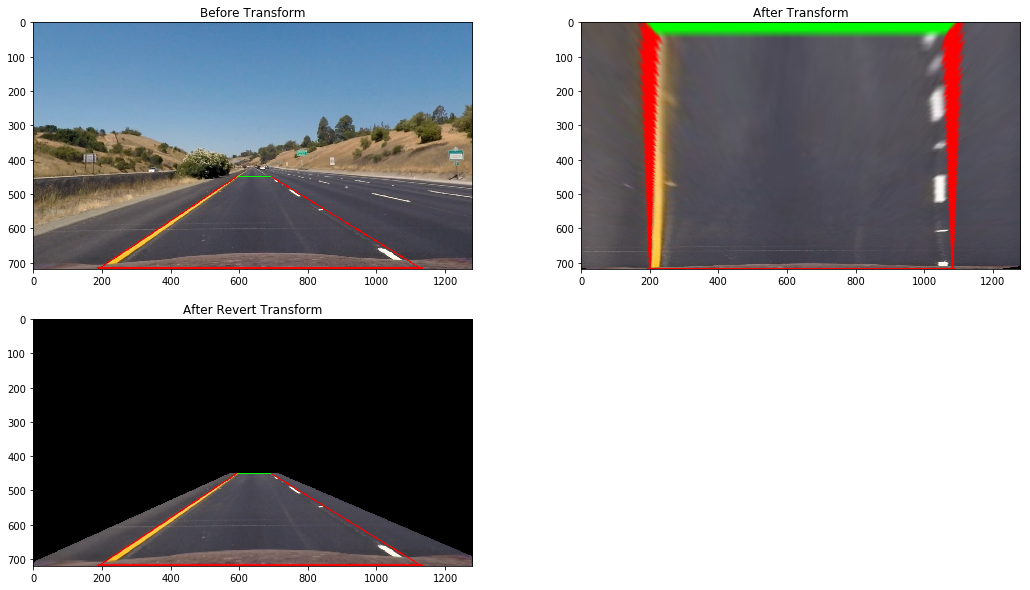

In [11]:
M, M_inverse = get_prespective_transform_matrix()

In [12]:
def bird_eyes_view(image, plot=False):
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
    if plot:
        images = []
        images.append(get_plot_dic(image, title="Original View", cmap='gray'))
        images.append(get_plot_dic(warped, title="Bird Eyes View", cmap='gray'))
        plot_multiple_images(images, rows=1, columns=2, figsize=(18, 15))
    return warped


def bird_eyes_view_to_original(image, plot=False):
    
    unwarped = cv2.warpPerspective(image, M_inverse, (image.shape[1], image.shape[0]))
    if plot:
        images = []
        images.append(get_plot_dic(image, title="Bird Eyes View", cmap='gray'))
        images.append(get_plot_dic(unwarped, title="Original View", cmap='gray'))
        plot_multiple_images(images, rows=1, columns=2, figsize=(18, 15))
    return unwarped
                      

Image path: test_images/test3.jpg


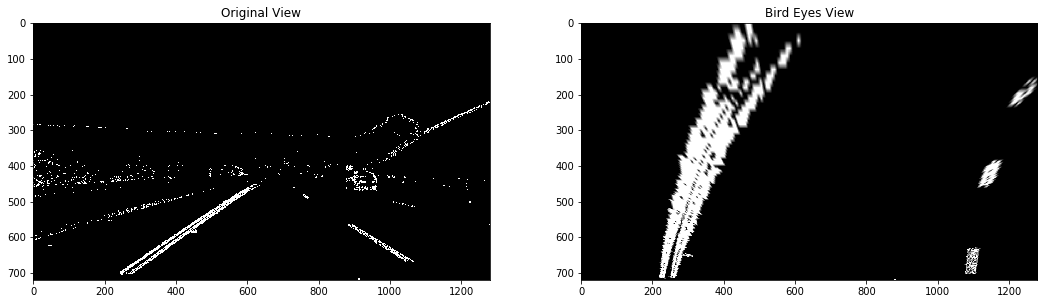

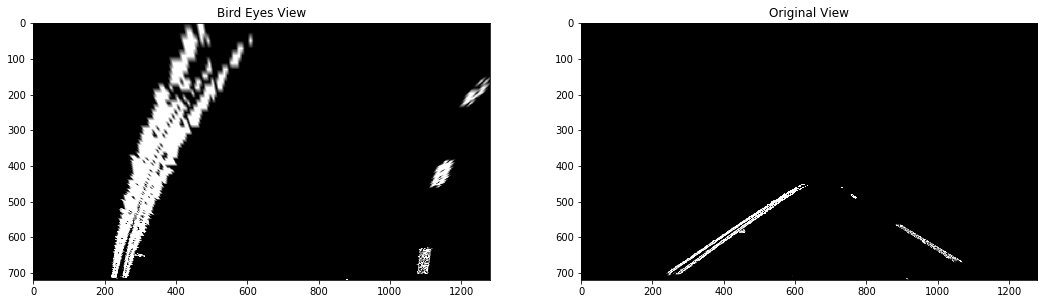

In [13]:
test_images = glob.glob('test_images/*.jpg')
img_path = random.choice(test_images)
print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

binary_img = create_thresholded_binary_image(image=cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), plot_images=False)
bird_view_img = bird_eyes_view(binary_img, plot=True)
original_view = bird_eyes_view_to_original(bird_view_img, plot=True)

## Detect Lane Pixels and Fit to Find the Lane Boundary.

In [14]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, plot=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Fit second order polynomial to for for points on real world
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    if plot:   
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
#         images = [get_plot_dic(out_image, "Curved Fitted Image")]
#         plot_multiple_images(images, rows=1, columns=1, figsize=(18, 30))
        plt.imshow(out_img)

    return left_fit, right_fit, left_fit_m, right_fit_m

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Fit second order polynomial to for for points on real world
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    
    return left_fit, right_fit, left_fit_m, right_fit_m

Image path: test_images/test1.jpg


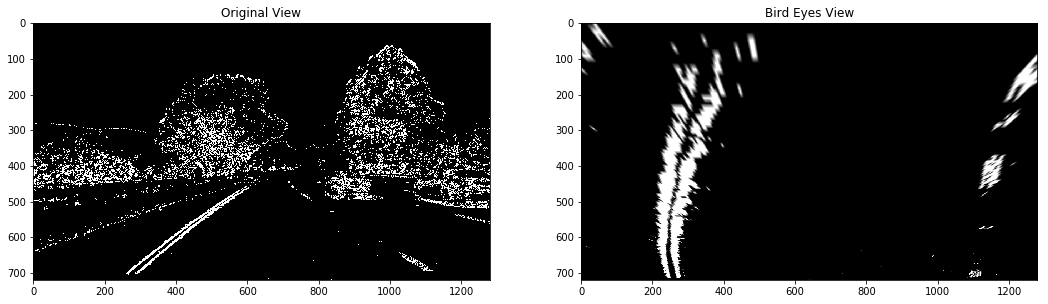

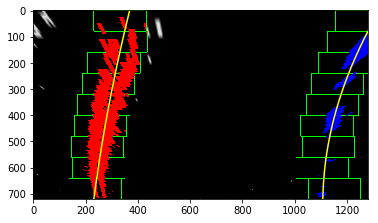

In [16]:
test_images = glob.glob('test_images/*.jpg')
img_path = random.choice(test_images)
img_path = 'test_images/test1.jpg'
print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

binary_img = create_thresholded_binary_image(image=cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), plot_images=False)
bird_view_img = bird_eyes_view(binary_img, plot=True)
left_fit, right_fit, _, _ = fit_polynomial(binary_warped=bird_view_img, plot=True)

## Curvature of the Lane and Vehicle Position with Respect to Center

In [17]:
def get_curvature(second_poly, y_eval):
    # Calculation of R_curve (radius of curvature)
    curverad = ((1 + (2*second_poly[0]*y_eval + second_poly[1])**2)**1.5) / np.absolute(2*second_poly[0])
    text = 'Radius of Curvature = {} (m)'.format(int(curverad))
    return text, curverad

def deviation_from_center(image, left_fit_m, right_fit_m):
    # Calculate vehicle center
    x_max = image.shape[1]*xm_per_pix
    y_max= image.shape[0]*ym_per_pix
    center = x_max / 2
    left_start = left_fit_m[0]*y_max**2 + left_fit_m[1]*y_max + left_fit_m[2]
    right_start = right_fit_m[0]*y_max**2 + right_fit_m[1]*y_max + right_fit_m[2]
    middle = left_start + (right_start - left_start)/2
    diff = middle - center
    if diff > 0:
        return 'Vehicle is {:.2f} m right of center'.format(diff)
    else:
        return 'Vehicle is {:.2f} m left of center'.format(abs(diff))
    

## Image Pipeline

In [18]:
def combine_image_and_found_lane(image, left_fit, right_fit, left_fit_m, right_fit_m):
    y_max = img.shape[0]
    ploty = np.linspace(0, y_max - 1, y_max)
    lanes = np.zeros_like(image).astype(np.uint8)
    
    # Find left and right points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(lanes, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    revert_transform = cv2.warpPerspective(lanes, M_inverse, (image.shape[1], image.shape[0])) 
    lanes_marked = cv2.addWeighted(image, 1, revert_transform, 0.3, 0)
    
    # Overlay font
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 2
    color = (255, 255, 255)
    curvature_text, curverad = get_curvature(second_poly=left_fit_m, y_eval=y_max*ym_per_pix)
    cv2.putText(lanes_marked, curvature_text, (50, 50), font, scale, color, 2)
    deviation_text = deviation_from_center(lanes_marked, left_fit_m, right_fit_m)
    cv2.putText(lanes_marked, deviation_text, (50, 120), font, scale, color, 2)
    
    return lanes_marked

def pipeline(image, plot=False, save_img=None, out_dir='output_images', left_fit=None, right_fit=None):
    """
    image: Should be in BGR format
    save_img: Prefix for save image name
    """
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    binary_img = create_thresholded_binary_image(image=cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), plot_images=False)
    bird_view_img = bird_eyes_view(binary_img, plot=False)
    
    if left_fit is None:
        left_fit, right_fit, left_fit_m, right_fit_m = fit_polynomial(binary_warped=bird_view_img)
    else:
        left_fit, right_fit, left_fit_m, right_fit_m= search_around_poly(bird_view_img, left_fit, right_fit)
        
    
    image_with_lanes = combine_image_and_found_lane(undist_img, left_fit, right_fit, left_fit_m, right_fit_m)
    
    if save_img is not None:
        cv2.imwrite(os.path.join(out_dir, '{}_original_image.jpg'.format(save_img)), image)
        cv2.imwrite(os.path.join(out_dir, '{}_undistort_image.jpg'.format(save_img)), undist_img)
        cv2.imwrite(os.path.join(out_dir, '{}_binary_image.jpg'.format(save_img)), binary_img)
        cv2.imwrite(os.path.join(out_dir, '{}_bird_eys_image.jpg'.format(save_img)), bird_view_img)
        cv2.imwrite(os.path.join(out_dir, '{}_final_output_image.jpg'.format(save_img)), image_with_lanes)
        
    if plot:
        images = []
        images.append(get_plot_dic(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'Original Image', cmap=None))
        images.append(get_plot_dic(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB), 'Undistort Image', cmap=None))
        images.append(get_plot_dic(binary_img, 'Binary Image', cmap='gray'))
        images.append(get_plot_dic(bird_view_img, 'Bird Eyes Image', cmap='gray'))
        images.append(get_plot_dic(cv2.cvtColor(image_with_lanes, cv2.COLOR_BGR2RGB), 'Final Output Image', cmap=None))
        
        plot_multiple_images(images, rows=3, columns=2, figsize=(18, 15))
    
    return image_with_lanes, left_fit, right_fit
    
    
    

## Run Pilpeline for Test Images

Image path: test_images/test3.jpg


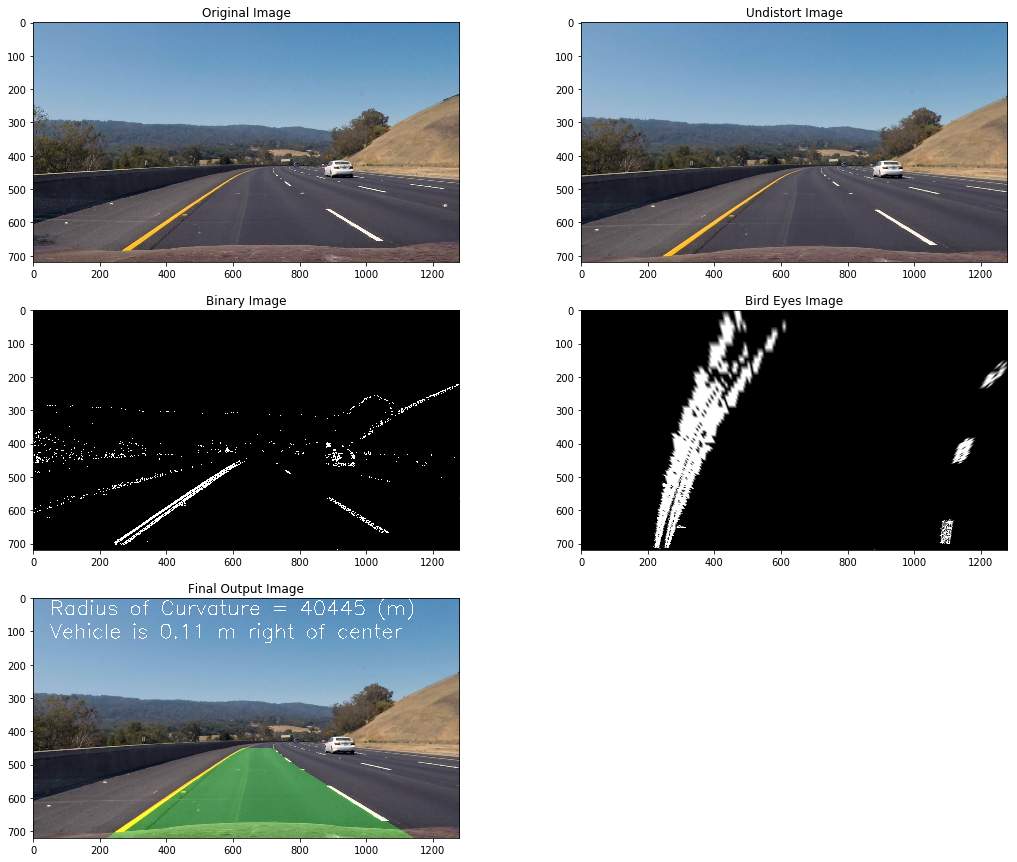

In [19]:
test_images = glob.glob('test_images/*.jpg')
img_path =test_images[0]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

Image path: test_images/test4.jpg


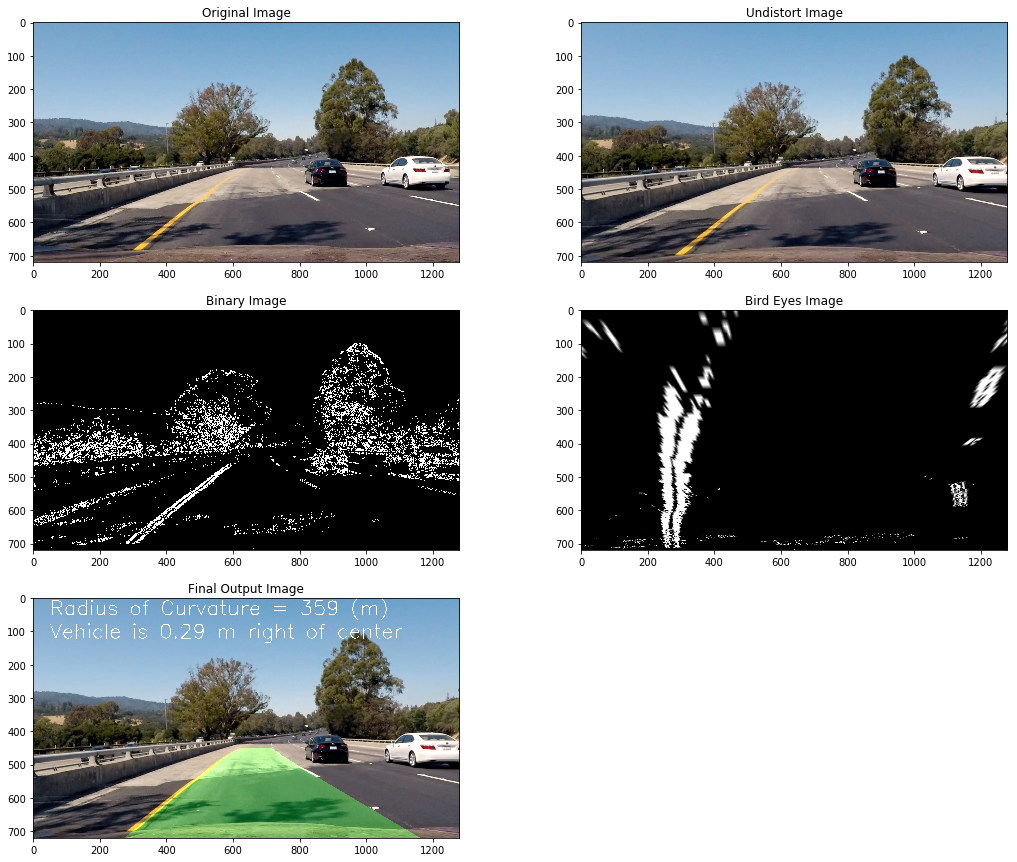

In [20]:
img_path =test_images[1]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

Image path: test_images/test6.jpg


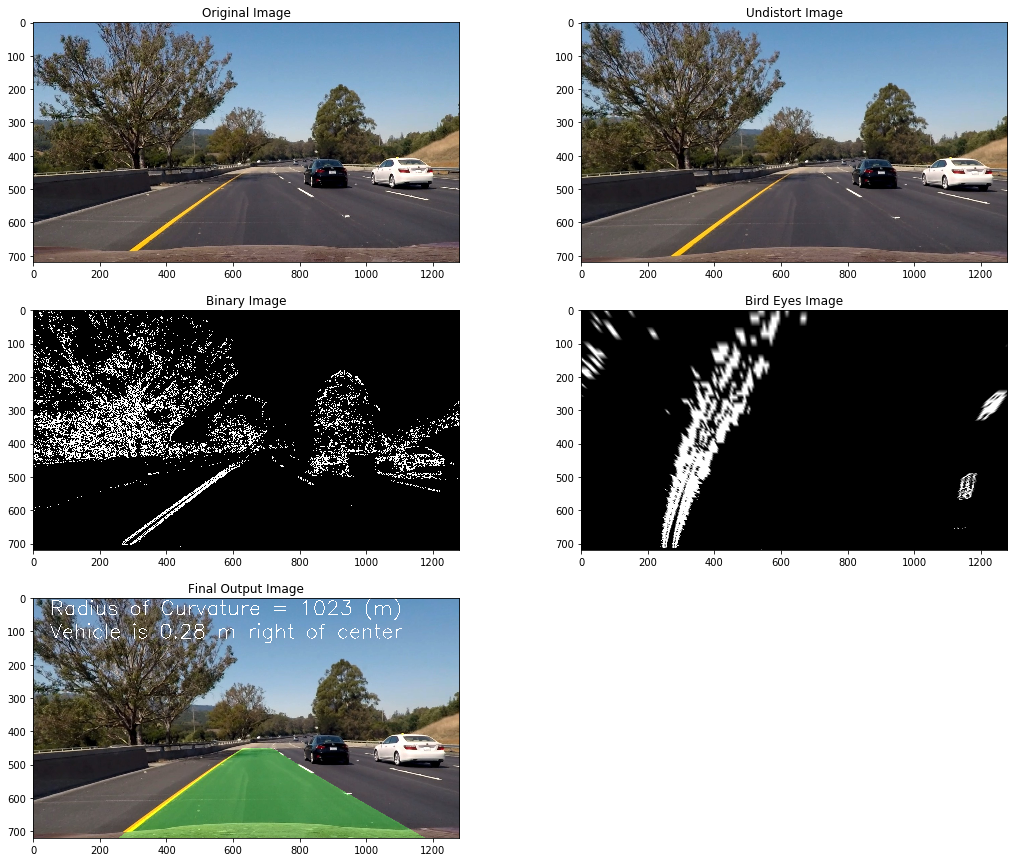

In [21]:
img_path =test_images[2]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

Image path: test_images/test1.jpg


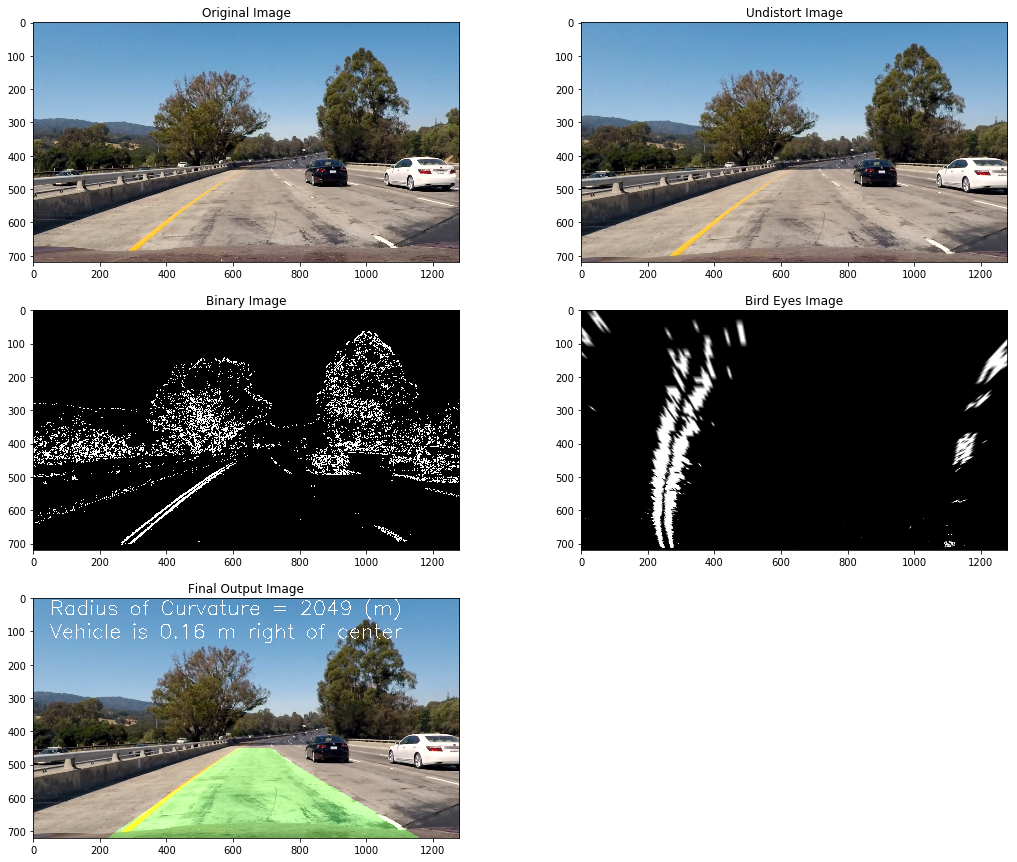

In [22]:
img_path =test_images[3]
image_name = os.path.basename(img_path)
print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)
out_image, left_fit, right_fit = pipeline(img, plot=True, save_img=os.path.splitext(image_name)[0])

Image path: test_images/test5.jpg


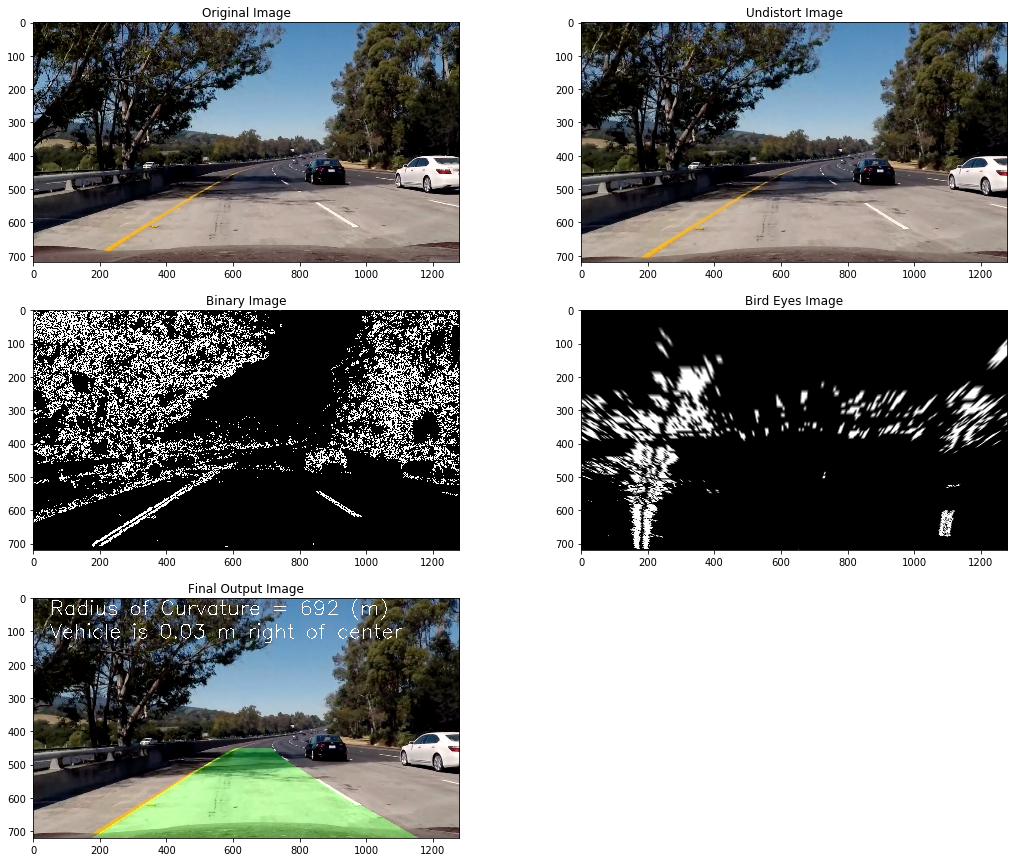

In [23]:
img_path =test_images[4]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

Image path: test_images/straight_lines1.jpg


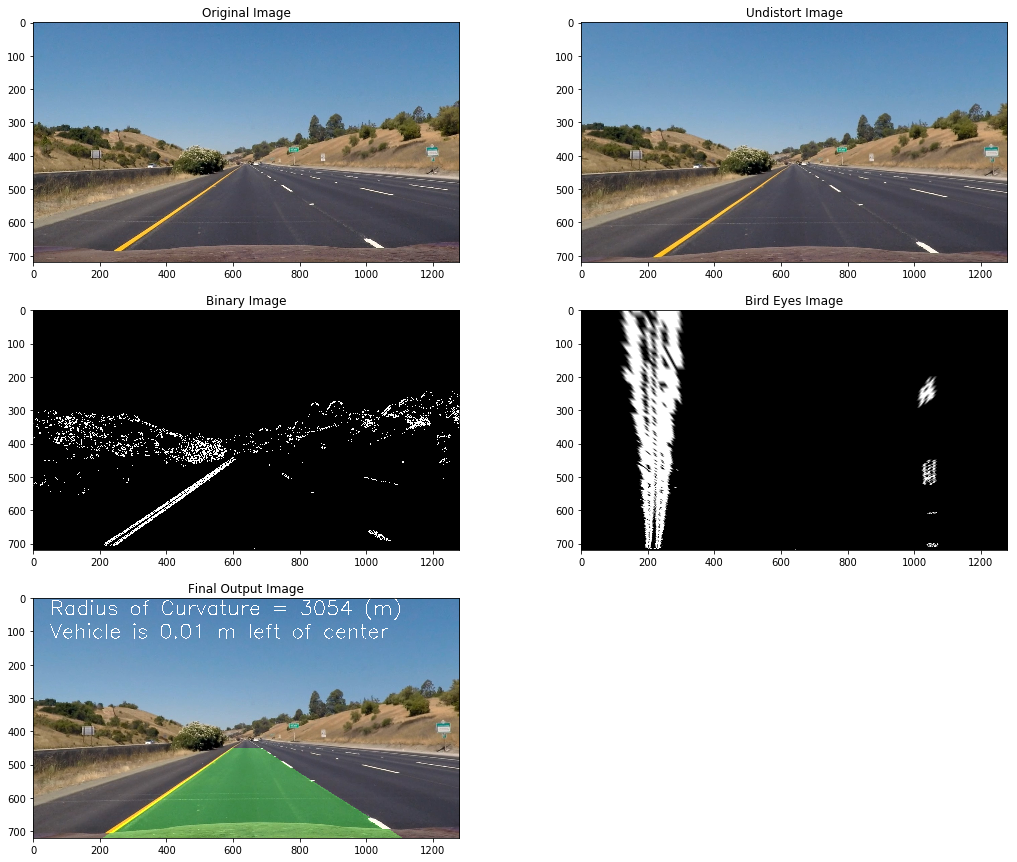

In [24]:
img_path =test_images[5]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

Image path: test_images/straight_lines2.jpg


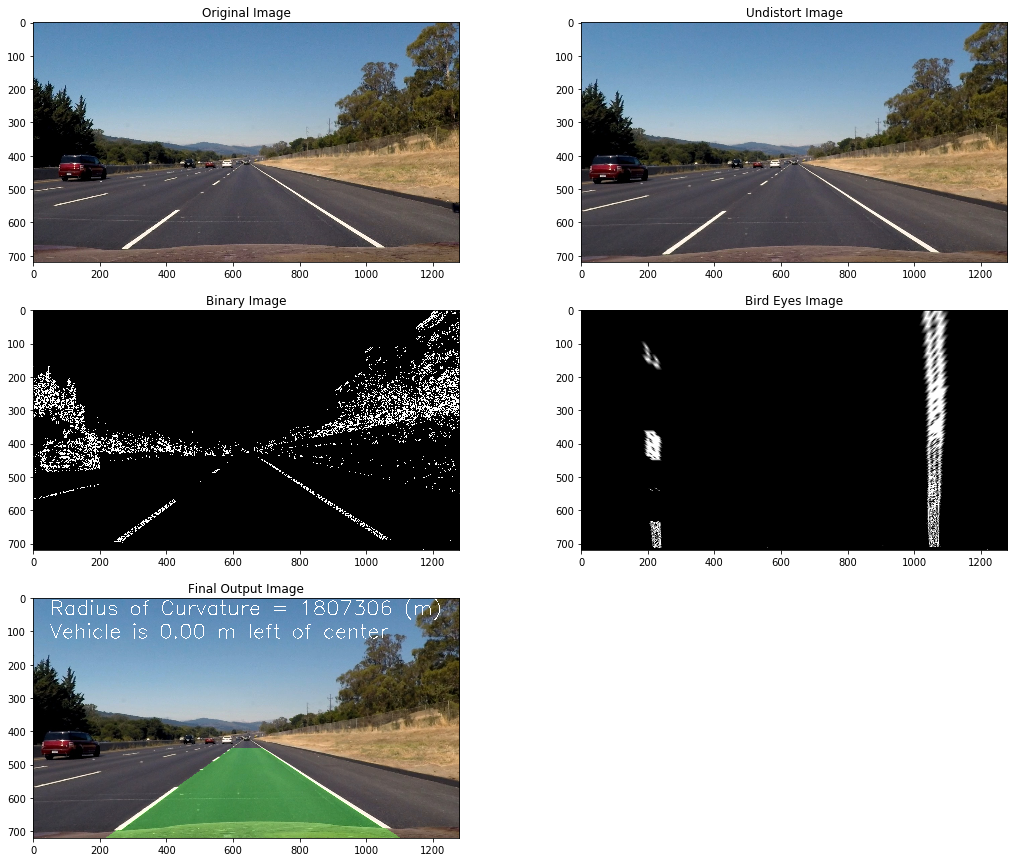

In [25]:
img_path =test_images[6]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

Image path: test_images/test2.jpg


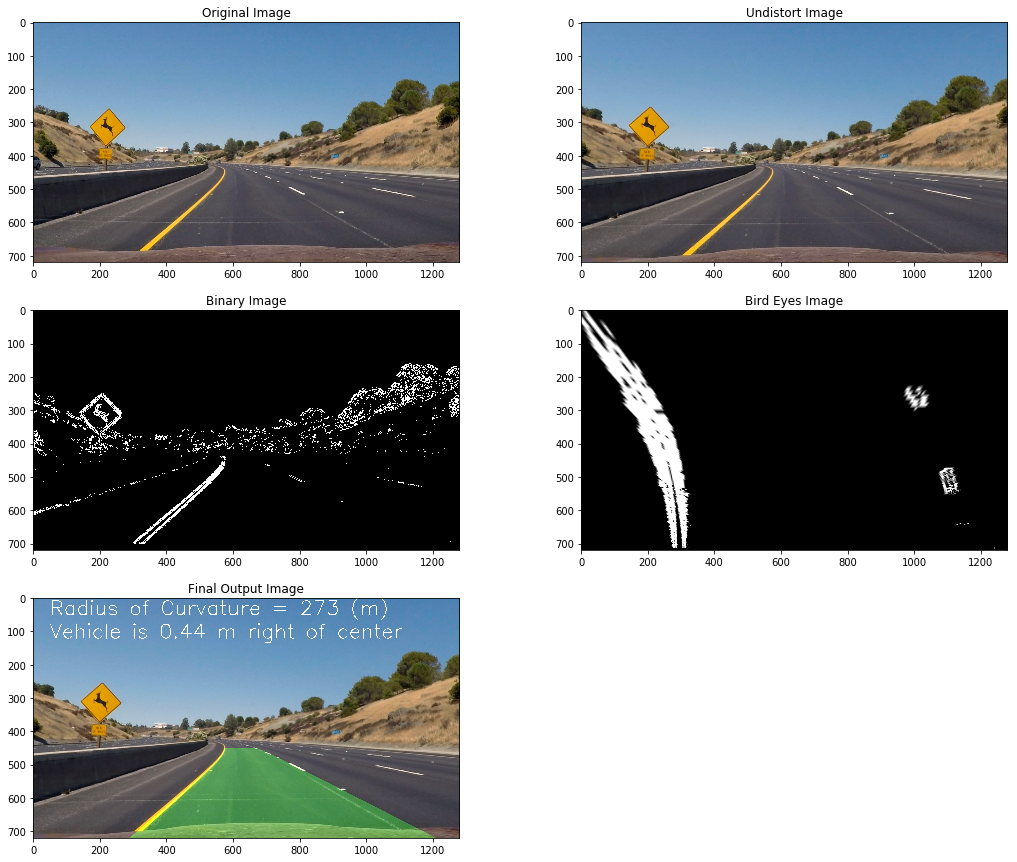

In [26]:
img_path =test_images[7]

print('Image path: {}'.format(img_path))
img = cv2.imread(img_path)

out_image, left_fit, right_fit = pipeline(img, plot=True)

## Video Pipeline

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
class VideoPipeline():
    def __init__(self, input_video, output_video):
        self.left_fit, self.right_fit = None, None
        self.clip = VideoFileClip(input_video)
        self.input_video = input_video
        self.output_video = output_video
        
    def image_pipeline(self, image):
        out_image, self.left_fit, self.right_fit = pipeline(image, left_fit=self.left_fit, 
                                                            right_fit=self.right_fit)
        return out_image
    
    def video_pipeline(self):
        clip = VideoFileClip(self.input_video)
        out_clip = clip.fl_image(self.image_pipeline) #NOTE: this function expects color images!!
        %time out_clip.write_videofile(self.output_video, audio=False)
        return
    

In [29]:
input_video='project_video.mp4'
output_video='project_video_output.mp4'
vp = VideoPipeline(input_video, output_video)
vp.video_pipeline()

t:   0%|          | 2/1260 [00:00<01:41, 12.45it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 7min 52s, sys: 9.86 s, total: 8min 2s
Wall time: 3min 54s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))